# Сравнение двух LLM и одной специфичной модели на основе результатов эмоций людей на фотографиях

Работу выполнили студенты группы БСМО-11-25:

* Аршинов Владислав
* Елохин Валерий
* Савин Даниил
* Якушенко Иван

Ссылка на используемый [датасет](https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition).
Ссылки на используемые модели: [специфичная модель](https://huggingface.co/dima806/facial_emotions_image_detection), [LLM 1](https://huggingface.co/google/gemma-3-27b-it), [LLM 2](https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct).

### Импорт библиотек

Сначала импортируем все нужные библиотеки и подготавливаем фотографии в формате base64 (чтобы можно было их загрузить в модель).

In [2]:
import base64
import re
import pandas as pd
import os
from huggingface_hub import InferenceClient
from natsort import natsorted
import numpy as np
import time
folder_path = "archive/images/"
base64_images = [
    base64.b64encode(open(os.path.join(folder_path, f), "rb").read()).decode('utf-8')
    for f in natsorted(os.listdir(folder_path))
    if os.path.isfile(os.path.join(folder_path, f))
]
output_gemma = []
output_qwen = []
print(f"Закодировано изображений: {len(base64_images)}")

Закодировано изображений: 39


### Обращение к специализированной модели (facial_emotions_image_detection от dima086)

In [112]:
client = InferenceClient(
    provider="hf-inference",
    api_key=os.environ["HF_TOKEN"],
)
output = []
for image in os.listdir(folder_path):
    output = output + client.image_classification(folder_path + image, model="dima806/facial_emotions_image_detection")
output

[ImageClassificationOutputElement(label='neutral', score=0.7460079789161682),
 ImageClassificationOutputElement(label='sad', score=0.1032661572098732),
 ImageClassificationOutputElement(label='fear', score=0.058445461094379425),
 ImageClassificationOutputElement(label='happy', score=0.04335441067814827),
 ImageClassificationOutputElement(label='angry', score=0.03251199424266815),
 ImageClassificationOutputElement(label='fear', score=0.6285816431045532),
 ImageClassificationOutputElement(label='surprise', score=0.2845604121685028),
 ImageClassificationOutputElement(label='angry', score=0.03126480057835579),
 ImageClassificationOutputElement(label='happy', score=0.0232162494212389),
 ImageClassificationOutputElement(label='sad', score=0.019774287939071655),
 ImageClassificationOutputElement(label='neutral', score=0.7392191290855408),
 ImageClassificationOutputElement(label='angry', score=0.09016966074705124),
 ImageClassificationOutputElement(label='sad', score=0.06350474059581757),
 Ima

### Обращение к первой LLM (Google Gemma)

In [141]:
client = InferenceClient(
    api_key=os.environ["HF_TOKEN"],
)
for i in range (0,39):
    completion = client.chat.completions.create(
        model="google/gemma-3-27b-it:scaleway",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "есть список эмоций: Angry Disgust Fear Happy Sad Surprise Neutral. Проанализируй фотографию и выведи вероятность принадлежности фото определенной эмоции. Ответ выведи в таком формате: 'Название эмоции': 'Вероятность дробным числом (например, 0.22, не 22%)'. Напиши только 5 самых возможных эмоций. Больше ничего не добавляй"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_images[i]}"
                        }
                    }
                ]
            }
        ],
    )
    output_gemma.append(completion.choices[0].message.content)
    time.sleep(10)
output_gemma

["'Neutral': '0.65'\n'Sad': '0.15'\n'Fear': '0.10'\n'Surprise': '0.05'\n'Disgust': '0.05'",
 "'Surprise': '0.85'\n'Fear': '0.10'\n'Neutral': '0.03'\n'Disgust': '0.01'\n'Sad': '0.01'",
 "'Fear': '0.78'\n'Surprise': '0.15'\n'Sad': '0.03'\n'Neutral': '0.02'\n'Disgust': '0.01'",
 "'Neutral': '0.75'\n'Sad': '0.12'\n'Fear': '0.05'\n'Disgust': '0.04'\n'Angry': '0.04'",
 "'Surprise': 0.65\n'Fear': 0.20\n'Neutral': 0.10\n'Sad': 0.03\n'Disgust': 0.02",
 "'Happy': '0.95'\n'Neutral': '0.03'\n'Surprise': '0.01'\n'Sad': '0.005'\n'Angry': '0.005'",
 "'Neutral': '0.78'\n'Sad': '0.11'\n'Fear': '0.05'\n'Disgust': '0.03'\n'Surprise': '0.03'",
 "'Neutral': '0.85'\n'Sad': '0.08'\n'Fear': '0.03'\n'Disgust': '0.02'\n'Surprise': '0.01'",
 "'Sad': '0.65'\n'Neutral': '0.20'\n'Angry': '0.07'\n'Disgust': '0.05'\n'Fear': '0.03'",
 "'Neutral': 0.75\n'Sad': 0.10\n'Fear': 0.05\n'Disgust': 0.04\n'Angry': 0.03",
 "'Neutral': 0.75\n'Sad': 0.12\n'Disgust': 0.05\n'Fear': 0.04\n'Surprise': 0.04",
 "'Neutral': '0.85'\n'Sad'

### Обращение ко второй LLM (Qwen 2.5)

In [142]:
client = InferenceClient(
    api_key=os.environ["HF_TOKEN"],
)
for i in range(0,39):
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-VL-7B-Instruct:hyperbolic",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "есть список эмоций: Angry Disgust Fear Happy Sad Surprise Neutral. Проанализируй фотографию и выведи вероятность принадлежности фото определенной эмоции. Ответ выведи в таком формате: 'Название эмоции': 'Вероятность дробным числом (например, 0.22, не 22%)'. Напиши только 5 самых возможных эмоций. Больше ничего не добавляй"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_images[i]}"
                        }
                    }
                ]
            }
        ],
    )
    output_qwen.append(completion.choices[0].message.content)
    time.sleep(10)
output_qwen

["'Angry': '0.45'\n'Neutral': '0.32'\n'Sad': '0.18'\n'Happy': '0.05'\n'Neutral': '0.05'",
 'Surprise: 0.85\nFear: 0.12\nAngry: 0.05\nDisgust: 0.02\nHappy: 0.01',
 'Neutral: 0.65\nHappy: 0.15\nSad: 0.10\nSurprise: 0.05\nFear: 0.05',
 'Neutral: 0.85\nHappy: 0.08\nSad: 0.06\nAngry: 0.03\nDisgust: 0.02',
 'Surprise: 0.65\nHappy: 0.20\nSad: 0.10\nNeutral: 0.05\nFear: 0.05',
 'Happy: 0.85\nNeutral: 0.10\nSad: 0.05\nSurprise: 0.03\nFear: 0.02',
 'Neutral: 0.95\nSad: 0.03\nDisgust: 0.02\nHappy: 0.01\nAngry: 0.01',
 'Angry: 0.95\nDisgust: 0.78\nNeutral: 0.15\nFear: 0.05\nSad: 0.02',
 "'Angry': '0.85'\n'Disgust': '0.15'\n'Fear': '0.05'\n'Happy': '0.02'\n'Sad': '0.03'",
 "'Neutral': '0.75'",
 "'Neutral': '0.30'  \n'Happy': '0.25'  \n'Sad': '0.20'  \n'Angry': '0.15'  \n'Neutral': '0.10'",
 'Neutral: 0.85\nAngry: 0.08\nDisgust: 0.05\nSad: 0.02\nHappy: 0.01',
 "'Fear': '0.45'\n'Angry': '0.30'\n'Neutral': '0.20'\n'Sad': '0.05'\n'Happy': '0.05'",
 "'Neutral': '0.15'\n'Happy': '0.20'\n'Surprise': '0.25

### Формируем датафрейм из данных от специализированной модели (facial_emotions_image_detection от dima086)

In [123]:
data = []
for i, result in enumerate(output):
    data.append({
        'labelF': result['label'],
        'scoreF': result['score']
    })
df = pd.DataFrame(data)
df

,labelF,scoreF
0,neutral,0.746008
1,sad,0.103266
2,fear,0.058445
3,happy,0.043354
4,angry,0.032512
...,...,...
190,surprise,0.699558
191,fear,0.167385
192,happy,0.060133
193,angry,0.034304


## Очищаем данные, полученные от Gemma
Убираем все лишнее, оставляем только названия эмоций и их оценку

In [143]:
filtered_gemma = []
allowed_words = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
pattern = r'\d+[,.]?\d*|%|' + '|'.join(re.escape(word) for word in allowed_words)
for string in output_gemma:
    matches = re.findall(pattern, string)
    filtered_string = ' '.join(matches)
    if filtered_string.startswith('5 '):
        filtered_string = filtered_string[2:]
    filtered_gemma.append(filtered_string)
filtered_gemma

['Neutral 0.65 Sad 0.15 Fear 0.10 Surprise 0.05 Disgust 0.05',
 'Surprise 0.85 Fear 0.10 Neutral 0.03 Disgust 0.01 Sad 0.01',
 'Fear 0.78 Surprise 0.15 Sad 0.03 Neutral 0.02 Disgust 0.01',
 'Neutral 0.75 Sad 0.12 Fear 0.05 Disgust 0.04 Angry 0.04',
 'Surprise 0.65 Fear 0.20 Neutral 0.10 Sad 0.03 Disgust 0.02',
 'Happy 0.95 Neutral 0.03 Surprise 0.01 Sad 0.005 Angry 0.005',
 'Neutral 0.78 Sad 0.11 Fear 0.05 Disgust 0.03 Surprise 0.03',
 'Neutral 0.85 Sad 0.08 Fear 0.03 Disgust 0.02 Surprise 0.01',
 'Sad 0.65 Neutral 0.20 Angry 0.07 Disgust 0.05 Fear 0.03',
 'Neutral 0.75 Sad 0.10 Fear 0.05 Disgust 0.04 Angry 0.03',
 'Neutral 0.75 Sad 0.12 Disgust 0.05 Fear 0.04 Surprise 0.04',
 'Neutral 0.85 Sad 0.10 Fear 0.03 Disgust 0.01 Surprise 0.01',
 'Neutral 0.65 Sad 0.15 Surprise 0.10 Disgust 0.05 Fear 0.05',
 'Surprise 0.75 Fear 0.15 Neutral 0.04 Disgust 0.03 Sad 0.03',
 'Angry 0.65 Sad 0.15 Disgust 0.10 Neutral 0.07 Fear 0.03',
 'Neutral 0.65 Sad 0.15 Disgust 0.10 Fear 0.05 Surprise 0.05',
 'S

### Очищаем данные, полученные от Qwen

In [144]:
filtered_qwen = []
for string in output_qwen:
    text = re.sub(r'\b\d+\.\s+', '', string)
    matches = re.findall(pattern, text)
    filtered_string_qwen = ' '.join(matches)
    filtered_string_qwen = ' '.join(dict.fromkeys(filtered_string_qwen.split()))
    filtered_qwen.append(filtered_string_qwen)
filtered_qwen

['Angry 0.45 Neutral 0.32 Sad 0.18 Happy 0.05',
 'Surprise 0.85 Fear 0.12 Angry 0.05 Disgust 0.02 Happy 0.01',
 'Neutral 0.65 Happy 0.15 Sad 0.10 Surprise 0.05 Fear',
 'Neutral 0.85 Happy 0.08 Sad 0.06 Angry 0.03 Disgust 0.02',
 'Surprise 0.65 Happy 0.20 Sad 0.10 Neutral 0.05 Fear',
 'Happy 0.85 Neutral 0.10 Sad 0.05 Surprise 0.03 Fear 0.02',
 'Neutral 0.95 Sad 0.03 Disgust 0.02 Happy 0.01 Angry',
 'Angry 0.95 Disgust 0.78 Neutral 0.15 Fear 0.05 Sad 0.02',
 'Angry 0.85 Disgust 0.15 Fear 0.05 Happy 0.02 Sad 0.03',
 'Neutral 0.75',
 'Neutral 0.30 Happy 0.25 Sad 0.20 Angry 0.15 0.10',
 'Neutral 0.85 Angry 0.08 Disgust 0.05 Sad 0.02 Happy 0.01',
 'Fear 0.45 Angry 0.30 Neutral 0.20 Sad 0.05 Happy',
 'Neutral 0.15 Happy 0.20 Surprise 0.25 Angry Fear',
 'Angry 0.72 Disgust 0.20 Fear 0.05 Neutral 0.03 Happy 0.02',
 'Neutral 0.40 Angry 0.30 Sad 0.15 Happy 0.10 Disgust 0.05',
 'Happy 0.15 Sad 0.20 Neutral 0.30 Angry Fear',
 'Neutral 0.95 Happy 0.03 Sad 0.02 Disgust 0.01 Angry',
 'Angry 0.85 Neut

### Формируем датафрейм из очищенных данных Gemma
Разделяем каждую строку на пары "label - score" и записываем в датафрейм

In [145]:
pattern = r'([A-Za-z]+)\s+(\d+\.\d+)'
all_data = []
for string in filtered_gemma:
    matches = re.findall(pattern, string)
    for label, score in matches:
        all_data.append({
            'labelG': label,
            'scoreG': float(score)
        })
df_gemma = pd.DataFrame(all_data)
df_gemma

,labelG,scoreG
0,Neutral,0.65
1,Sad,0.15
2,Fear,0.10
3,Surprise,0.05
4,Disgust,0.05
...,...,...
190,Angry,0.75
191,Sad,0.15
192,Disgust,0.05
193,Neutral,0.03


### Формируем датафрейм из очищенных данных Qwen

In [155]:
all_data = []
for i, string in enumerate(filtered_qwen):
    matches = re.findall(pattern, string)
    for label, score in matches:
        all_data.append({
            'row_index': i,
            'labelQ': label,
            'scoreQ': float(score)
        })
df_qwen = pd.DataFrame(all_data)
df_qwen

,row_index,labelQ,scoreQ
0,0,Angry,0.45
1,0,Neutral,0.32
2,0,Sad,0.18
3,0,Happy,0.05
4,1,Surprise,0.85
...,...,...,...
157,37,Neutral,0.25
158,37,Sad,0.10
159,38,Angry,0.95
160,38,Disgust,0.05


### Добавляем к каждой строке название соответствующей фотографии
Сначала берем все названия фотографий из соответствующей папки, потом повторяем каждое 5 раз и добавляем в датафрейм (здесь специализированная модель ответила 5 эмоциями на каждое фото, поэтому такой способ заполнения допустим)

In [4]:
all_files = os.listdir(folder_path)
photo_names = [f for f in all_files]
photo_names = natsorted(photo_names)
repeated_names = np.repeat(photo_names, 5)
df['photo_name'] = repeated_names
df['labelF'] = df['labelF'].str.capitalize()
df

,labelF,scoreF,photo_name
0,Neutral,0.746008,0Angry.jpg
1,Sad,0.103266,0Angry.jpg
2,Fear,0.058445,0Angry.jpg
3,Happy,0.043354,0Angry.jpg
4,Angry,0.032512,0Angry.jpg
...,...,...,...
190,Surprise,0.699558,18Angry.jpg
191,Fear,0.167385,18Angry.jpg
192,Happy,0.060133,18Angry.jpg
193,Angry,0.034304,18Angry.jpg


Здесь LLM (Gemma) так же выдала 5 эмоций на одно фото, поэтому способ идентичный

In [160]:
df_gemma['photo_name'] = repeated_names
df_gemma

,labelG,scoreG,photo_name
0,Neutral,0.65,0Angry.jpg
1,Sad,0.15,0Angry.jpg
2,Fear,0.10,0Angry.jpg
3,Surprise,0.05,0Angry.jpg
4,Disgust,0.05,0Angry.jpg
...,...,...,...
190,Angry,0.75,18Angry.jpg
191,Sad,0.15,18Angry.jpg
192,Disgust,0.05,18Angry.jpg
193,Neutral,0.03,18Angry.jpg


Здесь LLM (Qwen) выдавала различное количество эмоций на фотографию, поэтому фотографии присваиваются согласно столбцу *row_index*

In [161]:
df_qwen['photo_name'] = df_qwen['row_index'].apply(lambda x: photo_names[x])
df_qwen_f = df_qwen.drop('row_index',axis=1)
df_qwen_f

,labelQ,scoreQ,photo_name
0,Angry,0.45,0Angry.jpg
1,Neutral,0.32,0Angry.jpg
2,Sad,0.18,0Angry.jpg
3,Happy,0.05,0Angry.jpg
4,Surprise,0.85,0Fear.jpg
...,...,...,...
157,Neutral,0.25,17Happy.jpg
158,Sad,0.10,17Happy.jpg
159,Angry,0.95,18Angry.jpg
160,Disgust,0.05,18Angry.jpg


### Выгружаем полученные датафреймы в файлы
Это сделано для того, чтобы при дальнейшей работе эти датафреймы можно было просто считать с компьютера, а не запускать обращения снова

In [3]:
#df.to_csv('facial_data.csv')
#df_gemma.to_csv('gemma_data.csv')
#df_qwen_f.to_csv('qwen_data.csv')
df = pd.read_csv('facial_data.csv')
df_gemma = pd.read_csv('gemma_data.csv')
df_qwen_f = pd.read_csv('qwen_data.csv')

### В каждом датафрейме оставляем только одну подходящую строку на каждое фото
Подходящая строка - это та строка, в которой *score* максимален среди других строк, относящихся к одной фотографии 

In [4]:
res_df = df.loc[df.groupby('photo_name')['scoreF'].idxmax()]
res_df_gemma = df_gemma.loc[df_gemma.groupby('photo_name')['scoreG'].idxmax()]
res_df_qwen = df_qwen_f.loc[df_qwen_f.groupby('photo_name')['scoreQ'].idxmax()]
res_df_qwen

,labelQ,scoreQ,photo_name
0,Angry,0.45,0Angry.jpg
4,Surprise,0.85,0Fear.jpg
9,Neutral,0.65,0Neutral.jpg
100,Angry,0.85,10Surprise.jpg
103,Neutral,0.95,11Neutral.jpg
107,Neutral,0.55,11Sad.jpg
112,Disgust,0.45,12Disgust.jpg
116,Happy,0.35,12Fear.jpg
121,Surprise,0.85,12Surprise.jpg
126,Surprise,0.85,13Fear.jpg


### Добавляем столбец *emotion*
Этот столбец показывает фактическую эмоцию на фото

In [5]:
res_df['emotion'] = res_df['photo_name'].str.extract(r'(\D+)\.')[0]
res_df['labelF'] = res_df['labelF'].str.capitalize()
res_df_gemma['emotion'] = res_df_gemma['photo_name'].str.extract(r'(\D+)\.')[0]
res_df_qwen['emotion'] = res_df_qwen['photo_name'].str.extract(r'(\D+)\.')[0]

### Строим Confusion matrix для каждого датафрейма
Эти матрицы покажут, какое количество предсказанных значений совпало с фактическими значениями. 
Построим Confusion Matrix для специализированной модели

<Axes: xlabel='Предсказанные значения', ylabel='Фактические значения'>

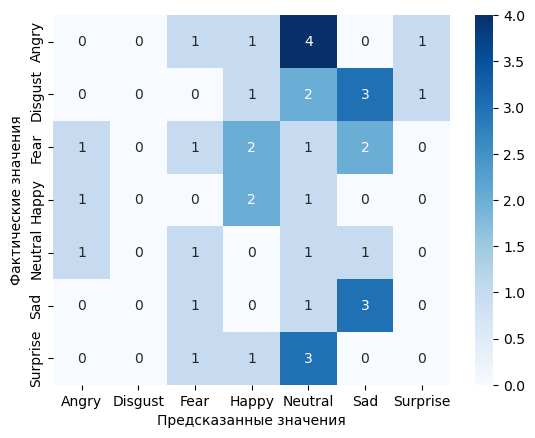

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(res_df['emotion'],res_df['labelF'])
sns_f = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = sorted(list(res_df['emotion'].unique())), yticklabels = sorted(list(res_df['emotion'].unique())))
sns_f.set_xlabel("Предсказанные значения")
sns_f.set_ylabel("Фактические значения")
sns_f

Теперь Confusion Matrix для Gemma

<Axes: xlabel='Предсказанные значения', ylabel='Фактические значения'>

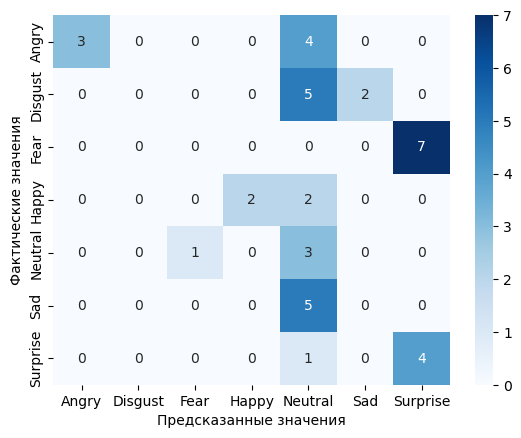

In [8]:
cm_gem = confusion_matrix(res_df_gemma['emotion'],res_df_gemma['labelG'])
sns_g = sns.heatmap(cm_gem, annot=True, fmt='d', cmap='Blues', xticklabels = sorted(list(res_df_gemma['emotion'].unique())), yticklabels = sorted(list(res_df_gemma['emotion'].unique())))
sns_g.set_xlabel("Предсказанные значения")
sns_g.set_ylabel("Фактические значения")
sns_g

Наконец, Confusion Matrix для Qwen

<Axes: xlabel='Предсказанные значения', ylabel='Фактические значения'>

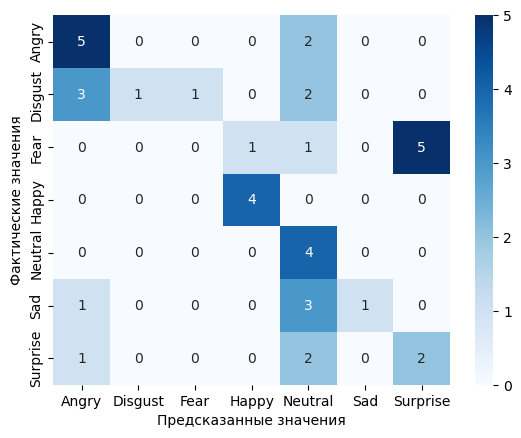

In [7]:
cm_qwen = confusion_matrix(res_df_qwen['emotion'],res_df_qwen['labelQ'])
sns_q = sns.heatmap(cm_qwen, annot=True, fmt='d', cmap='Blues', xticklabels = sorted(list(res_df_qwen['emotion'].unique())), yticklabels = sorted(list(res_df_qwen['emotion'].unique())))
sns_q.set_xlabel("Предсказанные значения")
sns_q.set_ylabel("Фактические значения")
sns_q

### Строим отчеты о классификации для всех трёх моделей
Precision(Точность) – показывает, какая доля объектов, выделенных как положительные, действительно являются положительными

Recall(Полнота) – показывает, какая доля положительных объектов была правильно идентифицирована моделью

F1-score(F-мера) – показывает гармоническое среднее между Precision и Recall. Чем ближе значение F1-score к 1, тем лучше модель справляется с задачей классификации.

Специализированная модель:

In [10]:
from sklearn.metrics import accuracy_score, brier_score_loss, classification_report
print(classification_report(res_df['emotion'], res_df['labelF'], zero_division=np.nan))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         7
     Disgust        nan      0.00      0.00         7
        Fear       0.20      0.14      0.17         7
       Happy       0.29      0.50      0.36         4
     Neutral       0.08      0.25      0.12         4
         Sad       0.33      0.60      0.43         5
    Surprise       0.00      0.00      0.00         5

    accuracy                           0.18        39
   macro avg       0.15      0.21      0.15        39
weighted avg       0.14      0.18      0.13        39



Gemma:

In [11]:
print(classification_report(res_df_gemma['emotion'], res_df_gemma['labelG'], zero_division=np.nan))

              precision    recall  f1-score   support

       Angry       1.00      0.43      0.60         7
     Disgust        nan      0.00      0.00         7
        Fear       0.00      0.00      0.00         7
       Happy       1.00      0.50      0.67         4
     Neutral       0.15      0.75      0.25         4
         Sad       0.00      0.00      0.00         5
    Surprise       0.36      0.80      0.50         5

    accuracy                           0.31        39
   macro avg       0.42      0.35      0.29        39
weighted avg       0.42      0.31      0.27        39



Qwen:

In [12]:
print(classification_report(res_df_qwen['emotion'], res_df_qwen['labelQ'], zero_division=np.nan))

              precision    recall  f1-score   support

       Angry       0.50      0.71      0.59         7
     Disgust       1.00      0.14      0.25         7
        Fear       0.00      0.00      0.00         7
       Happy       0.80      1.00      0.89         4
     Neutral       0.29      1.00      0.44         4
         Sad       1.00      0.20      0.33         5
    Surprise       0.29      0.40      0.33         5

    accuracy                           0.44        39
   macro avg       0.55      0.49      0.41        39
weighted avg       0.55      0.44      0.37        39



### Добавляем столбец *is_correct*
Он потребуется для расчета *brier_score*. В нем просто указано, в каких строках фактическое значение и предсказанное совпадают

In [91]:
df['is_correct'] = (df['labelF'] == df['emotion']).astype(int)
df_gemma['is_correct'] = (df_gemma['labelG'] == df_gemma['emotion']).astype(int)
df_qwen_f['is_correct'] = (df_qwen_f['labelQ'] == df_qwen_f['emotion']).astype(int)
df_qwen_f

,labelQ,scoreQ,photo_name,emotion,is_correct
0,Angry,0.45,0Angry.jpg,Angry,1
1,Neutral,0.32,0Angry.jpg,Angry,0
2,Sad,0.18,0Angry.jpg,Angry,0
3,Happy,0.05,0Angry.jpg,Angry,0
4,Surprise,0.85,0Fear.jpg,Fear,0
...,...,...,...,...,...
157,Neutral,0.25,17Happy.jpg,Happy,0
158,Sad,0.10,17Happy.jpg,Happy,0
159,Angry,0.95,18Angry.jpg,Angry,1
160,Disgust,0.05,18Angry.jpg,Angry,0


### Рассчитываем brier-score
Brier Score — это метрика от 0 до 1, которая показывает точность вероятностных прогнозов, измеряя среднюю квадратичную ошибку между предсказанной вероятностью и фактическим исходом. Чем меньше значение Brier Score, тем лучше модель

In [97]:
scores = []
for photo_name in df['photo_name'].unique():
    temp = df[df['photo_name'] == photo_name]
    # Истинные метки (one-hot)
    y_true_binary = temp['is_correct'].values
    # Предсказанные вероятности
    y_prob = temp['scoreF'].values
    # Brier Score
    bs = np.mean((y_prob - y_true_binary) ** 2)
    scores.append(bs)
brier_score_facial = np.mean(scores)
scores_gemma = []
for photo_name in df_gemma['photo_name'].unique():
    temp_gemma = df_gemma[df_gemma['photo_name'] == photo_name]
    # Истинные метки (one-hot)
    y_true_binary_gemma = temp_gemma['is_correct'].values
    # Предсказанные вероятности
    y_prob_gemma = temp_gemma['scoreG'].values
    # Brier Score
    bs_gemma = np.mean((y_prob_gemma - y_true_binary_gemma) ** 2)
    scores_gemma.append(bs_gemma)
brier_score_gemma = np.mean(scores_gemma)
scores_qwen = []
for photo_name in df_qwen_f['photo_name'].unique():
    temp_qwen = df_qwen_f[df_qwen_f['photo_name'] == photo_name]
    # Истинные метки (one-hot)
    y_true_binary_qwen = temp_qwen['is_correct'].values
    # Предсказанные вероятности
    y_prob_qwen = temp_qwen['scoreQ'].values
    # Brier Score
    bs_qwen = np.mean((y_prob_qwen - y_true_binary_qwen) ** 2)
    scores_qwen.append(bs_qwen)
brier_score_qwen = np.mean(scores_qwen)
print(f"facial model: {brier_score_facial}\ngemma: {brier_score_gemma}\nqwen: {brier_score_qwen}")

facial model: 0.1549180080479835
gemma: 0.1820535897435897
qwen: 0.13028324786324783
